# regression hw in week 12

**info**

SuJinhua 2017201620

# Tool&Dataset

In [1]:
import torch
import pandas as pd
import numpy as np
from auto_relation_test import multiple_linear_regression
df_1 = pd.read_excel('table9-16.xlsx')
df_2 = pd.read_excel('table9-17.xlsx')


In [2]:
def multilinear_test(X,y):
    X -= X.mean(axis = 0)
    return np.linalg.inv(X.T.dot(X)).diagonal()
def ridge_regression(X,y,k=1):
    beta = np.linalg.inv(X.T.dot(X) + k * np.eye(X.shape[1])).dot(X.T.dot(y))
    return beta            
def regression(X,y,add_ones =True):
    if add_ones:
        X = np.hstack((np.ones((X.shape[0],1)),X))
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    return beta            

# Question 9.4

## Subproblem 1

The logistic function can be converted into this following form.

$$\log{(\frac{1}{y}-\frac{1}{u})}=\log{b_0} +\log{b_1} \times t$$

In [3]:
u = 100
t_=df_1[['t']].to_numpy()
y_ = np.log((1 /df_1['y'].to_numpy()) - 1/u)
beta_ =regression(t_,y_)
print('before modify:',beta_)
real_beta = np.exp(beta_)
print('after modify:',real_beta)

before modify: [-1.85066306 -0.26437437]
after modify: [0.15713294 0.76768609]


## Subproblem 2

In [4]:
t = torch.tensor(df_1[['t']].to_numpy())
y = torch.tensor(df_1[['y']].to_numpy())
class sigmoid(torch.nn.Module):
    def __init__(self,u,b0,b1):
        super(sigmoid,self).__init__()
        self.u = torch.tensor(u,dtype=float,requires_grad = True)
        self.b0 = torch.tensor(b0,dtype=float,requires_grad = True)
        self.b1 = torch.tensor(b1,dtype=float,requires_grad = True)
        
    def forward(self,x):
        return 1/(self.b0*self.b1**x + (1/self.u))

In [5]:
def test(b0,b1):
    fuc = sigmoid(100,b0,b1)
    optimizer = torch.optim.SGD([fuc.u,fuc.b0,fuc.b1],lr = 1e-6)
    loss_func = torch.nn.MSELoss()
    for i in range(100):
        optimizer.zero_grad()
        loss_func(fuc(t),y).backward()
        optimizer.step()
    print('MSE:',loss_func(fuc(t),y))
    print('u:',fuc.u,\
          '\nb0:',fuc.b0,\
          '\nb1:',fuc.b1)
test(0.2,0.5)

MSE: tensor(17.4423, dtype=torch.float64, grad_fn=<MseLossBackward>)
u: tensor(99.9988, dtype=torch.float64, requires_grad=True) 
b0: tensor(0.2651, dtype=torch.float64, requires_grad=True) 
b1: tensor(0.7274, dtype=torch.float64, requires_grad=True)


In [6]:
test(0.3,0.6)

MSE: tensor(23.4894, dtype=torch.float64, grad_fn=<MseLossBackward>)
u: tensor(99.9994, dtype=torch.float64, requires_grad=True) 
b0: tensor(0.3148, dtype=torch.float64, requires_grad=True) 
b1: tensor(0.7163, dtype=torch.float64, requires_grad=True)


In [7]:
test(0.15,0.7)

MSE: tensor(8.3812, dtype=torch.float64, grad_fn=<MseLossBackward>)
u: tensor(99.9998, dtype=torch.float64, requires_grad=True) 
b0: tensor(0.1708, dtype=torch.float64, requires_grad=True) 
b1: tensor(0.7567, dtype=torch.float64, requires_grad=True)


## conclusion for 9.4

I use calculating graph method in pytorch to calculate the partial derivative of b0 and b1, set learning rate at 1e-6 and step at 100 to suit the unit of data. By several experiments, It can be found that initial value had a distinguish effect on the final MSE, because it is not a convex optimaztion question, but we find the best result by newton iteration method is fairly close to the results of Linear OLS method.

# Question 9.5

## Subproblem 1

CD function can be converted into following form.
$$\log{y}=\log{A} + \alpha \log{K} + \beta \log{L}$$

In [8]:
u = 100
GDP_=np.log(df_2['GDP'].to_numpy())
X_=np.log(df_2[['K','L']].to_numpy())
beta_ =regression(X_,GDP_)
print('before modify:',beta_)
beta_[0] = np.exp(beta_[0])
print('after modify:',beta_)

before modify: [-1.78544553  0.80106971  0.40163736]
after modify: [0.16772232 0.80106971 0.40163736]


## Subproblem2

In [9]:
X = torch.tensor(df_2[['K','L']].to_numpy())
y = torch.tensor(df_2[['GDP']].to_numpy())
class CD1(torch.nn.Module):
    def __init__(self,A,alpha,beta):
        super(CD1,self).__init__()
        self.A = torch.tensor(A,dtype=float,requires_grad = True)
        self.alpha = torch.tensor(alpha,dtype=float,requires_grad = True)
        self.beta = torch.tensor(beta,dtype=float,requires_grad = True)
    def forward(self,x):
        return self.A*(x[:,0]**self.alpha)*(x[:,1]**self.beta)

In [10]:
def test1(A,alpha,beta):
    fuc = CD1(A,alpha,beta)
    optimizer = torch.optim.SGD([fuc.A,fuc.alpha,fuc.beta],lr = 1e-12)
    loss_func = torch.nn.MSELoss()
    for i in range(100):
        optimizer.zero_grad()
        if i == 0:
            print('MSE_init:',loss_func(fuc(X),y))
        loss_func(fuc(X),y).backward()
        optimizer.step()
    print('MSE:',loss_func(fuc(X),y))
    print('A:',fuc.A,\
          '\nalpha:',fuc.alpha,\
          '\nbeta:',fuc.beta)
test1(0.16,0.8,0.4)

MSE_init: tensor(69283599.0876, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(65172096.5956, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(0.1565, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.7908, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.3925, dtype=torch.float64, requires_grad=True)


/ssd/bqw/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [11]:
test1(0.2,0.8,0.4)

MSE_init: tensor(88941281.1800, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(64662755.1592, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(0.1920, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.7819, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.3814, dtype=torch.float64, requires_grad=True)


In [12]:
test1(0.5,0.8,0.4)

MSE_init: tensor(7.7937e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(62335771.1241, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(0.4876, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.7416, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.3303, dtype=torch.float64, requires_grad=True)


In [13]:
test1(1,0.7,0.3)

MSE_init: tensor(60187764.7485, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(60095607.8138, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(1.0002, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.6973, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.3008, dtype=torch.float64, requires_grad=True)


# Subproblem 3

In [14]:
multilinear_test(X_,GDP_)

array([ 1.32871737, 12.44298677])

In [15]:
for k in range(10):
    print(ridge_regression(X_,GDP_,k))

[0.80106971 0.40163736]
[0.76919068 0.2534312 ]
[0.71019425 0.22989701]
[0.65904986 0.21201667]
[0.61465053 0.19710526]
[0.5758106  0.18429385]
[0.54156728 0.17310926]
[0.51115785 0.16323697]
[0.48397603 0.15444823]
[0.45953561 0.14656857]


# Subproblem 4


method: OLS
-------------------
GDP = 9.151700235746734 + 0.8010697129440203*K_1 + 0.4016373640795834*L_2
DW_value: 0.7840601925462866
rho: 0.6079699037268567
error figure on each explanatory varible:



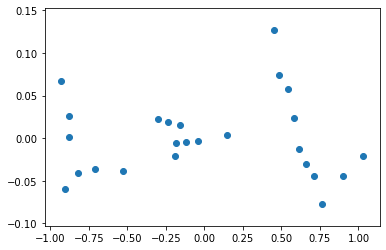

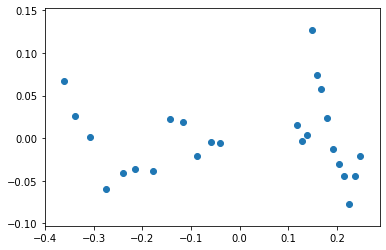


method: first_order_difference
-------------------
delta_GDP = 0.04397861569393563 + 0.4104722966125654*delta_K_1 + 0.06810540545515875*delta_L_2
DW_value: 2.288410614292613
rho: -0.14420530714630653
error figure on each explanatory varible:



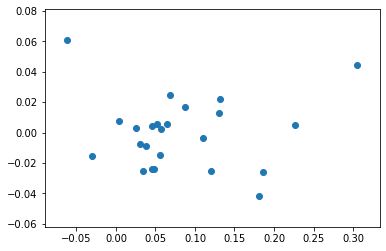

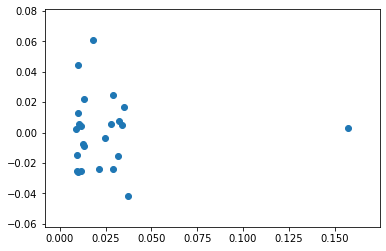

In [16]:
mlr = multiple_linear_regression(GDP_,X_,'GDP','K','L')
for t in ['OLS','first_order_difference']:
    mlr.pretty_report(t)

## conclusion for 9.5

Since there are power operations, the MSE loss will be considerably big when the initial value of parameter is not good. So use OLS method to estimate rough value of the parameter and then use newton iteration method to find a fine result of smaller MSE. In this question the multi_linear relationship is obvious especially variable L. When using ridge regression(regularization), setting k at 7 will get a stable result. As for the sub-question 4, I will the module I write in the hw in week 8. I use first order difference method. It is very obvious that before and after K = 8.5 or L =15, the variance of epsilon is different. And my method really improve DW 0.7 to 2.2.

# Question 9.6

## Subproblem 1

CD function can be converted into following form.
$$\log{y}=\log{A} + \alpha \log{K} + \beta \log{L} + \mu t$$

In [17]:
u = 100
GDP_=np.log(df_2['GDP'].to_numpy())
X_=np.hstack((np.log(df_2[['K','L']].to_numpy()),df_2[['t']]))
beta_ =regression(X_,GDP_)
print('before modify:',beta_)
beta_[0] = np.exp(beta_[0])
print('after modify:',beta_)

before modify: [ 5.1592565   0.46007932 -0.02780137  0.04184914]
after modify: [ 1.74035012e+02  4.60079321e-01 -2.78013716e-02  4.18491385e-02]


## Subproblem2

In [18]:
X = torch.tensor(df_2[['K','L','t']].to_numpy())
y = torch.tensor(df_2[['GDP']].to_numpy())
class CD2(torch.nn.Module):
    def __init__(self,A,alpha,beta,mu):
        super(CD2,self).__init__()
        self.A = torch.tensor(A,dtype=float,requires_grad = True)
        self.alpha = torch.tensor(alpha,dtype=float,requires_grad = True)
        self.beta = torch.tensor(beta,dtype=float,requires_grad = True)
        self.mu = torch.tensor(mu,dtype=float,requires_grad = True)
    def forward(self,x):
        return self.A*(x[:,0]**self.alpha)*(x[:,1]**self.beta)*torch.exp(self.mu*x[:,2])

In [19]:
def test2(A,alpha,beta,mu):
    fuc = CD2(A,alpha,beta,mu)
    optimizer = torch.optim.SGD([fuc.A,fuc.alpha,fuc.beta,fuc.mu],lr = 1e-11)
    loss_func = torch.nn.MSELoss()
    for i in range(100):
        optimizer.zero_grad()
        if i == 0:
            print('MSE_init:',loss_func(fuc(X),y))
        loss_func(fuc(X),y).backward()
        optimizer.step()
    print('MSE:',loss_func(fuc(X),y))
    print('A:',fuc.A,\
          '\nalpha:',fuc.alpha,\
          '\nbeta:',fuc.beta,\
          '\nmu:',fuc.mu)
test2(174,0.46,-0.028,0.042)

MSE_init: tensor(76360578.3998, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(38172543.5526, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(174.0000, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.5070, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.0529, dtype=torch.float64, requires_grad=True) 
mu: tensor(-0.0437, dtype=torch.float64, requires_grad=True)


In [20]:
test2(174,0.5,0.05,-0.043)

MSE_init: tensor(38956314.5647, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(38158050.5390, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(174.0000, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.5034, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.0570, dtype=torch.float64, requires_grad=True) 
mu: tensor(-0.0446, dtype=torch.float64, requires_grad=True)


In [21]:
test2(200,0.5,0.05,-0.043)

MSE_init: tensor(38562244.6778, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(38150174.9774, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(200.0000, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.4974, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.0479, dtype=torch.float64, requires_grad=True) 
mu: tensor(-0.0439, dtype=torch.float64, requires_grad=True)


In [22]:
test2(200,0.4,0.05,0.043)

MSE_init: tensor(1.9349e+08, dtype=torch.float64, grad_fn=<MseLossBackward>)
MSE: tensor(38075741.5783, dtype=torch.float64, grad_fn=<MseLossBackward>)
A: tensor(200.0000, dtype=torch.float64, requires_grad=True) 
alpha: tensor(0.4242, dtype=torch.float64, requires_grad=True) 
beta: tensor(0.0959, dtype=torch.float64, requires_grad=True) 
mu: tensor(-0.0384, dtype=torch.float64, requires_grad=True)


# Subproblem 3

In [23]:
multilinear_test(X_,GDP_)

array([ 4.16692794, 16.94454385,  0.04274973])

In [26]:
for k in range(20):
    print(ridge_regression(X_,GDP_,k))

[ 0.46007932 -0.02780137  0.04184914]
[0.09404873 0.00196325 0.07237617]
[0.05509163 0.00215599 0.07565244]
[0.04018956 0.00218899 0.07686905]
[0.03231667 0.00219771 0.07748324]
[0.02744754 0.00219987 0.07783995]
[0.02413772 0.0021997  0.07806301]
[0.02174097 0.00219856 0.07820784]
[0.0199248  0.002197   0.07830296]
[0.01850069 0.00219525 0.07836453]
[0.01735376 0.00219339 0.07840241]
[0.01641003 0.0021915  0.07842294]
[0.01561969 0.0021896  0.07843041]
[0.01494798 0.0021877  0.07842778]
[0.0143699  0.00218581 0.07841722]
[0.01386703 0.00218394 0.07840028]
[0.01342548 0.00218208 0.07837818]
[0.01303456 0.00218024 0.07835183]
[0.01268596 0.00217841 0.07832193]
[0.01237308 0.0021766  0.07828905]


# Subproblem 4

X is a singular matrix!

method: OLS
-------------------
GDP = 9.151700235746734 + 0.4600793213075747*K_1 + -0.027801371567633737*L_2 + 0.04184913845069893*t_3
DW_value: 1.473570182988354
rho: 0.26321490850582296
error figure on each explanatory varible:



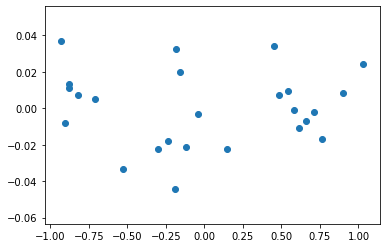

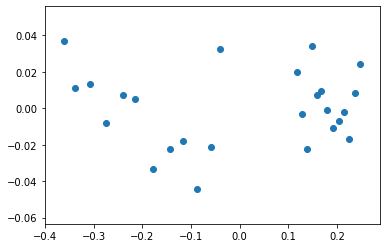

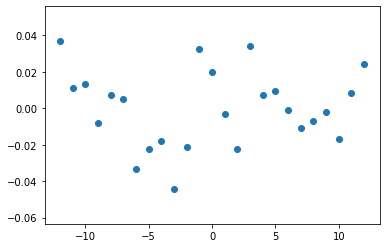


method: iteration_method
-------------------
[GDP(t) - rho * GDP(t-1)] = 6.744536521545069 + 0.46735829702926424*[K(t) - rho * K(t-1)]_1 + -0.031039409055971134*[L(t) - rho * L(t-1)]_2 + 0.040665575677988564*[t(t) - rho * t(t-1)]_3
DW_value: 1.9326483843215039
rho: 0.03367580783924806
error figure on each explanatory varible:



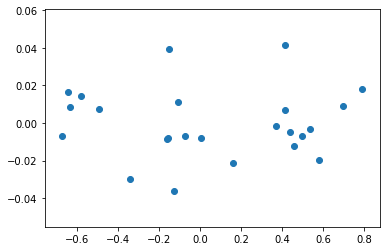

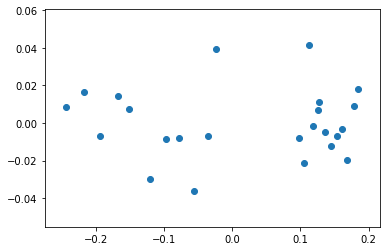

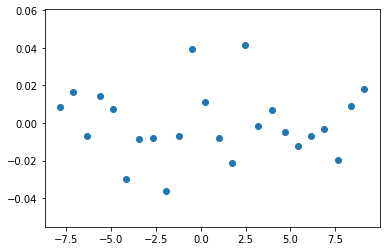

In [25]:
mlr = multiple_linear_regression(GDP_,X_,'GDP','K','L','t')
for t in ['OLS','iteration_method']:
    mlr.pretty_report(t)

## conclusion for 9.6

This question is almost a duplicate of 9.5. The key point is that whether the technology development has an obvious effect on the economy development. The result is e^mu = 1.04 while increase rate of GDP is about 9%, so other factors have 1.05 mutli power. So technology really work on production. Also these question needn't have too much fine-tuning. I guess the function may be a convex function locally.

Because the K and L indeed relate with t theoritically, the multi-linear problem is severer. We choose k at 20 to do the ridge regressionn.

When consider time-effect, auto_releted problem seems to get eased. Note that because t increase in a fixed number, so the X input for first order difference method is a singular matrix. Therefore we can only use iteration method, and finally this method get it down.